In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import os.path
import copy
import seaborn as sns
# import lovely_tensors as lt

from utils.others import w, detach_var, rsetattr, rgetattr, count_parameters, print_grads, \
    load_l2o_opter_ckpt, load_baseline_opter_ckpt
from utils.visualization import get_model_dot
from training import do_fit, fit_normal, fit_optimizer
from analysis import get_rescale_sym_constraint_deviation, get_translation_sym_constraint_deviations, \
    get_scale_sym_constraint_deviation, get_baseline_opter_param_updates
from target import MNISTLoss
from optimizer import Optimizer
from optimizee import MNISTNet, MNISTNet2Layer, MNISTNetBig, MNISTRelu, MNISTLeakyRelu, \
    MNISTSimoidBatchNorm, MNISTReluBatchNorm
from meta_module import *

# lt.monkey_patch()
sns.set(color_codes=True)
sns.set_style("white")

In [ ]:
TARGET_CLS = MNISTLoss
# OPTIMIZEE_CLS = MNISTRelu
# OPTIMIZEE_CONFIG = None
OPTIMIZEE_CLS = MNISTReluBatchNorm
OPTIMIZEE_CONFIG = {"affine": True, "track_running_stats": False}
OPTIMIZER_CLS = Optimizer
OPTIMIZER_PREPROC = True
N_ITERS = 500
N_TESTS = 10
OPTEE_UPDATES_LR = 0.01 # 0.01 for relu optimizees, 0.1 for others
CKPT_ITER_FREQ = 5
CKPT_BASE_DIR = "./ckpt"
CKPT_PREFIX = f"{TARGET_CLS.__name__}_{OPTIMIZEE_CLS.__name__}_{OPTIMIZER_CLS.__name__}_"

# Only for L2O model training
N_EPOCHS = 75
N_OPTIM_RUNS_PER_EPOCH = 20
TRAINING_N_ITERS = 200
OPTIMIZER_LR = 0.01
UNROLL = 20

In [12]:
os.makedirs(CKPT_BASE_DIR, exist_ok=True)

## Prepare L2O optimizer

In [ ]:
### load pretrained L2O optimizer model
ckpt = torch.load(os.path.join(CKPT_BASE_DIR, "l2o_optimizer.pt"))
opter = w(OPTIMIZER_CLS(preproc=OPTIMIZER_PREPROC))
opter.load_state_dict(ckpt["state_dict"])
loss = ckpt["loss"]
print(f"{loss=}")

In [ ]:
### meta-train a new L2O optimizer model
fit_opter_args = dict(
    target_cls=TARGET_CLS,
    optee_cls=OPTIMIZEE_CLS,
    optee_config=OPTIMIZEE_CONFIG,
    n_epochs=N_EPOCHS,
    n_optim_runs_per_epoch=N_OPTIM_RUNS_PER_EPOCH,
    n_tests=1, # not that important during meta-training
    n_iters=TRAINING_N_ITERS,
    unroll=UNROLL,
    opter_lr=OPTIMIZER_LR,
    optee_updates_lr=OPTEE_UPDATES_LR,
    preproc=OPTIMIZER_PREPROC,
    ckpt_iter_freq=CKPT_ITER_FREQ,
    ckpt_prefix=f"{TARGET_CLS.__name__}_{OPTIMIZEE_CLS.__name__}_{Optimizer.__name__}_",
    ckpt_dir=os.path.join(CKPT_BASE_DIR, "l2o_optimizer"),
)
loss, opter_state_dict = fit_optimizer(**fit_opter_args)
opter = w(OPTIMIZER_CLS(preproc=OPTIMIZER_PREPROC))
opter.load_state_dict(opter_state_dict)
print(loss)

# save the final model
fit_opter_args_to_save = fit_opter_args.copy()
fit_opter_args_to_save["target_cls"] = fit_opter_args["target_cls"].__name__
fit_opter_args_to_save["optee_cls"] = fit_opter_args["optee_cls"].__name__
torch.save({
    "state_dict": opter_state_dict,
    "fit_optimizer_args": fit_opter_args_to_save,
    "loss": loss,
}, os.path.join(CKPT_BASE_DIR, f"{CKPT_PREFIX}final.pt")) # save in base checkpoints dir

## Train optimizee with L2O optimizer

optimizer:   0%|          | 0/10 [00:00<?, ?it/s]

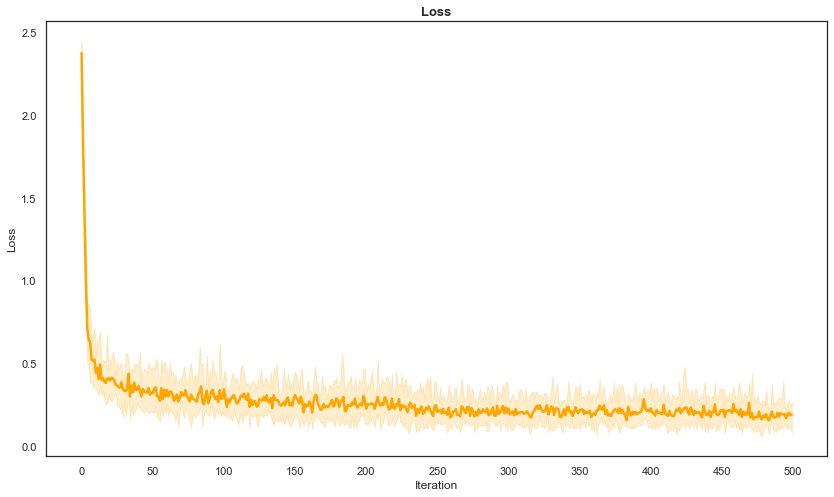

In [14]:
np.random.seed(0)

L2O_OPTIMIZER_CKPT_DIR = os.path.join(CKPT_BASE_DIR, "l2o_optimizer")
L2O_OPTIMIZER_CKPT_PREFIX = f"{TARGET_CLS.__name__}_{OPTIMIZEE_CLS.__name__}_{OPTIMIZER_CLS.__name__}_"
do_fit_args = dict(
    opter=opter,
    opter_optim=None,
    target_cls=TARGET_CLS,
    optee_cls=OPTIMIZEE_CLS,
    optee_config=OPTIMIZEE_CONFIG,
    unroll=1,
    n_iters=N_ITERS,
    optee_updates_lr=OPTEE_UPDATES_LR,
    train_opter=False,
    ckpt_iter_freq=CKPT_ITER_FREQ,
    ckpt_prefix=L2O_OPTIMIZER_CKPT_PREFIX,
    ckpt_dir=L2O_OPTIMIZER_CKPT_DIR,
)
losses = np.array([
    do_fit(**do_fit_args) for _ in tqdm(range(N_TESTS), "optimizer")
])

fig = plt.figure(figsize=(14, 8))
x_ticks = np.arange(0, N_ITERS + 1, 50)
ax = fig.add_subplot(111)
ax.plot(np.mean(losses, axis=0), color="orange", linewidth=2.5)
ax.fill_between(
    x=np.arange(losses.shape[1]),
    y1=np.min(losses, axis=0),
    y2=np.max(losses, axis=0),
    color="orange",
    alpha=0.2,
)

ax.set_title("Loss", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_xticks(x_ticks)
plt.show()

## Compare with baseline optimizers (Adam, SGD, RMSprop, ...)

In [15]:
BASELINE_OPTERS = [
    ("Adam", optim.Adam, {"lr": 0.03}),
    # ("RMSprop", optim.RMSprop, {"lr": 0.003}),
    ("SGD", optim.SGD, {"lr": 0.1, "momentum": 0.9}),
    # ("NAG", optim.SGD, {"lr": 0.1, "nesterov": True, "momentum": 0.9})
]

baseline_fit_stats = dict()
for (opter_name, baseline_opter_cls, extra_kwargs) in BASELINE_OPTERS:
    np.random.seed(0)
    
    # prepare checkpointing
    ckpt_prefix = f"{TARGET_CLS.__name__}_{OPTIMIZEE_CLS.__name__}_{opter_name}_"
    ckpt_dir = os.path.join(CKPT_BASE_DIR, opter_name)
    os.makedirs(ckpt_dir, exist_ok=True)
    
    # train
    baseline_fit_stats[opter_name] = np.array(fit_normal(
        target_cls=TARGET_CLS,
        optee_cls=OPTIMIZEE_CLS,
        optee_config=OPTIMIZEE_CONFIG,
        opter_cls=baseline_opter_cls,
        n_iters=N_ITERS,
        n_tests=N_TESTS,
        ckpt_iter_freq=CKPT_ITER_FREQ,
        ckpt_prefix=ckpt_prefix,
        ckpt_dir=ckpt_dir,
        **extra_kwargs
    ))

Adam - tests:   0%|          | 0/10 [00:00<?, ?it/s]

SGD - tests:   0%|          | 0/10 [00:00<?, ?it/s]

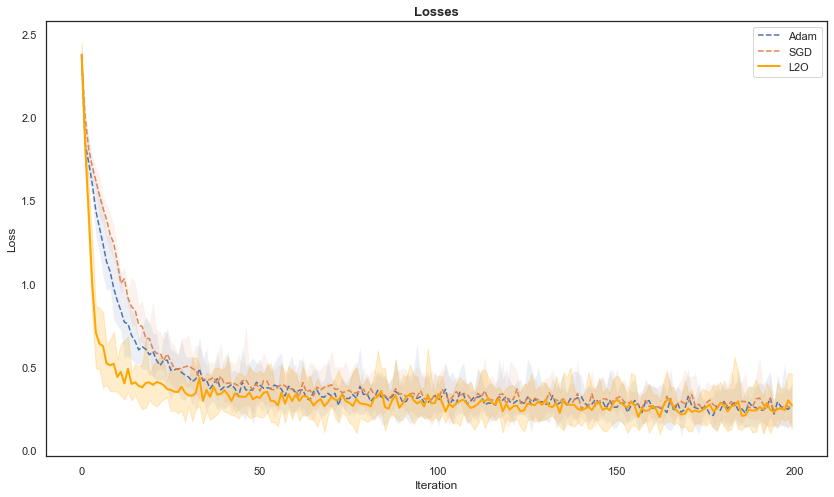

In [24]:
### plot comparison
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
show_max_iters = 200

# plot baseline optimizers
for opter_name, opter_losses in baseline_fit_stats.items():
    sns.lineplot(
        np.mean(opter_losses[:,:show_max_iters], axis=0),
        label=opter_name,
        linestyle="--",
        ax=ax,
    )
    ax.fill_between(
        x=range(opter_losses[:,:show_max_iters].shape[1]),
        y1=np.min(opter_losses[:,:show_max_iters], axis=0),
        y2=np.max(opter_losses[:,:show_max_iters], axis=0),
        alpha=0.1,
    )

# plot L2O optimizer
sns.lineplot(
    np.mean(losses[:,:show_max_iters], axis=0),
    label="L2O",
    color="orange",
    linewidth=2,
    ax=ax,
)
ax.fill_between(
    x=range(losses[:,:show_max_iters].shape[1]),
    y1=np.min(losses[:,:show_max_iters], axis=0),
    y2=np.max(losses[:,:show_max_iters], axis=0),
    alpha=0.2,
    color="orange",
)

ax.set_title("Losses", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
x_ticks = np.arange(0, show_max_iters + 1, 50)
ax.set_xticks(x_ticks)
plt.show()

# Analyze

In [25]:
### plot the norm and mean abs value of parameters, gradients, and parameter updates across training
SELECTED_OPTIMIZER = "L2O optimizer" # "L2O optimizer", "SGD", "Adam"

to_plot = {k: {} for k in ["param_norms", "param_abs_means", "grad_norms", "grad_abs_means", "updates_norms", "updates_abs_means"]}
for iter_i in range(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ):
    if SELECTED_OPTIMIZER == "L2O optimizer":
        # load L2O optimizer
        optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
            path=os.path.join(L2O_OPTIMIZER_CKPT_DIR, f"{L2O_OPTIMIZER_CKPT_PREFIX}{iter_i}.pt"),
            optee_cls=OPTIMIZEE_CLS,
            opter_cls=OPTIMIZER_CLS,
            optee_config=OPTIMIZEE_CONFIG,
            opter_config={"preproc": OPTIMIZER_PREPROC}
        )
    else:
        # load baseline optimizer
        baseline_opter = [b_opter for b_opter in BASELINE_OPTERS if b_opter[0] == SELECTED_OPTIMIZER][0]
        ckpt_prefix = f"{TARGET_CLS.__name__}_{OPTIMIZEE_CLS.__name__}_{baseline_opter[0]}_"
        ckpt_dir = os.path.join(CKPT_BASE_DIR, baseline_opter[0])
        optee, opter, optee_grads, loss_history = load_baseline_opter_ckpt(
            path=os.path.join(ckpt_dir, f"{ckpt_prefix}{iter_i}.pt"),
            optee_cls=OPTIMIZEE_CLS,
            opter_cls=baseline_opter[1],
            optee_config=OPTIMIZEE_CONFIG,
            opter_config=baseline_opter[2]
        )
        optee_updates = get_baseline_opter_param_updates(optee, opter)
    for n, p in optee.all_named_parameters():
        for k in to_plot:
            if n not in to_plot[k]:
                to_plot[k][n] = []
        to_plot["param_norms"][n].append(p.norm().item())
        to_plot["param_abs_means"][n].append(p.abs().mean().item())
        to_plot["grad_norms"][n].append(p.grad.norm().item())
        to_plot["grad_abs_means"][n].append(p.grad.abs().mean().item())
        to_plot["updates_norms"][n].append(optee_updates[n].norm().item())
        to_plot["updates_abs_means"][n].append(optee_updates[n].abs().mean().item())

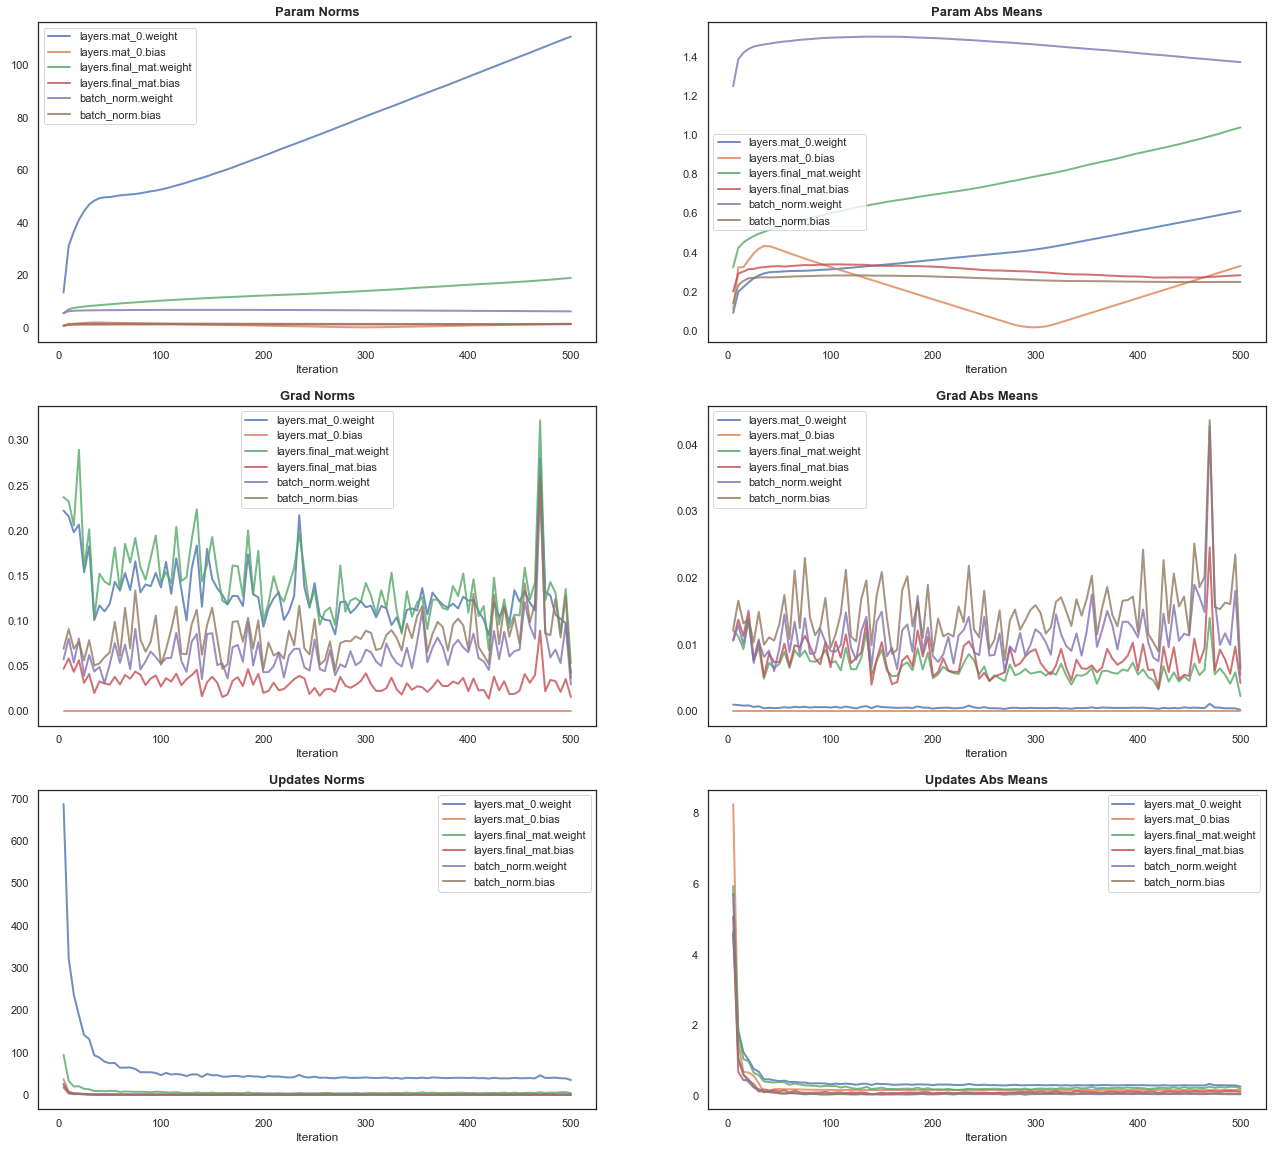

In [26]:
### plot
fig = plt.figure(figsize=(22, 20))
x_ticks = np.arange(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ)

for i, k in enumerate(to_plot.keys()):
    ax = fig.add_subplot(3, 2, i + 1)
    for n in to_plot[k]:
        sns.lineplot(x=x_ticks, y=to_plot[k][n], label=n, alpha=0.8, linewidth=2, ax=ax)
    ax.set_title(k.replace("_", " ").title(), fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.legend()
plt.show()

## Rescale symmetry (ReLU, LeakyReLU, Linear, ...)

### During meta-testing

In [27]:
rescale_sym_grad_deviations = dict()
rescale_sym_update_deviations = dict()

In [28]:
### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
rescale_sym_grad_deviations["L2O Optimizer"] = []
rescale_sym_update_deviations["L2O Optimizer"] = []
for iter_i in range(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ):
    # load checkpoint
    optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
        path=os.path.join(L2O_OPTIMIZER_CKPT_DIR, f"{L2O_OPTIMIZER_CKPT_PREFIX}{iter_i}.pt"),
        optee_cls=OPTIMIZEE_CLS,
        opter_cls=OPTIMIZER_CLS,
        optee_config=OPTIMIZEE_CONFIG,
        opter_config={"preproc": OPTIMIZER_PREPROC}
    )

    # calculate deviations
    rescale_sym_grad_deviations["L2O Optimizer"].append(get_rescale_sym_constraint_deviation(
        W1=optee.layers.mat_0.weight.cpu(),
        b=optee.layers.mat_0.bias.cpu(),
        W2=optee.layers.final_mat.weight.cpu(),
        W1_update=optee_grads["layers.mat_0.weight"].cpu(),
        b_update=optee_grads["layers.mat_0.bias"].cpu(),
        W2_update=optee_grads["layers.final_mat.weight"].cpu()
    ))
    rescale_sym_update_deviations["L2O Optimizer"].append(get_rescale_sym_constraint_deviation(
        W1=optee.layers.mat_0.weight.cpu(),
        b=optee.layers.mat_0.bias.cpu(),
        W2=optee.layers.final_mat.weight.cpu(),
        W1_update=-1 * optee_updates["layers.mat_0.weight"].cpu(),
        b_update=-1 * optee_updates["layers.mat_0.bias"].cpu(),
        W2_update=-1 * optee_updates["layers.final_mat.weight"].cpu()
    ))

rescale_sym_grad_deviations["L2O Optimizer"] = np.array(rescale_sym_grad_deviations["L2O Optimizer"])
rescale_sym_update_deviations["L2O Optimizer"] = np.array(rescale_sym_update_deviations["L2O Optimizer"])
print(f"{rescale_sym_grad_deviations['L2O Optimizer'].shape=}")
print(f"{rescale_sym_update_deviations['L2O Optimizer'].shape=}")

rescale_sym_grad_deviations['L2O Optimizer'].shape=(100,)
rescale_sym_update_deviations['L2O Optimizer'].shape=(100,)


In [31]:
### Baseline optimizers
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
BASELINE_OPTERS_TO_COLLECT_FOR = list(filter(lambda opter: opter[0] in ["Adam", "SGD"], BASELINE_OPTERS))

for (opter_name, baseline_opter_cls, extra_kwargs) in BASELINE_OPTERS_TO_COLLECT_FOR:
    ckpt_prefix = f"{TARGET_CLS.__name__}_{OPTIMIZEE_CLS.__name__}_{opter_name}_"
    ckpt_dir = os.path.join(CKPT_BASE_DIR, opter_name)
    rescale_sym_grad_deviations[opter_name] = []
    rescale_sym_update_deviations[opter_name] = []
    for iter_i in range(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ):
        optee, opter, optee_grads, loss_history = load_baseline_opter_ckpt(
            path=os.path.join(ckpt_dir, f"{ckpt_prefix}{iter_i}.pt"),
            optee_cls=OPTIMIZEE_CLS,
            opter_cls=baseline_opter_cls,
            optee_config=OPTIMIZEE_CONFIG,
            opter_config=extra_kwargs
        )
        optee_updates = get_baseline_opter_param_updates(optee, opter)
        rescale_sym_grad_deviations[opter_name].append(get_rescale_sym_constraint_deviation(
            W1=optee.layers.mat_0.weight.cpu(),
            b=optee.layers.mat_0.bias.cpu(),
            W2=optee.layers.final_mat.weight.cpu(),
            W1_update=optee_grads["layers.mat_0.weight"].cpu(),
            b_update=optee_grads["layers.mat_0.bias"].cpu(),
            W2_update=optee_grads["layers.final_mat.weight"].cpu()
        ))
        rescale_sym_update_deviations[opter_name].append(get_rescale_sym_constraint_deviation(
            W1=optee.layers.mat_0.weight.cpu(),
            b=optee.layers.mat_0.bias.cpu(),
            W2=optee.layers.final_mat.weight.cpu(),
            W1_update=-1 * optee_updates["layers.mat_0.weight"].cpu(),
            b_update=-1 * optee_updates["layers.mat_0.bias"].cpu(),
            W2_update=-1 * optee_updates["layers.final_mat.weight"].cpu()
        ))

    rescale_sym_grad_deviations[opter_name] = np.array(rescale_sym_grad_deviations[opter_name])
    rescale_sym_update_deviations[opter_name] = np.array(rescale_sym_update_deviations[opter_name])
    print(f"rescale_sym_grad_deviations[{opter_name}].shape={rescale_sym_grad_deviations[opter_name].shape}")
    print(f"rescale_sym_update_deviations[{opter_name}].shape={rescale_sym_update_deviations[opter_name].shape}")

rescale_sym_grad_deviations[Adam].shape=(100,)
rescale_sym_update_deviations[Adam].shape=(100,)
rescale_sym_grad_deviations[SGD].shape=(100,)
rescale_sym_update_deviations[SGD].shape=(100,)


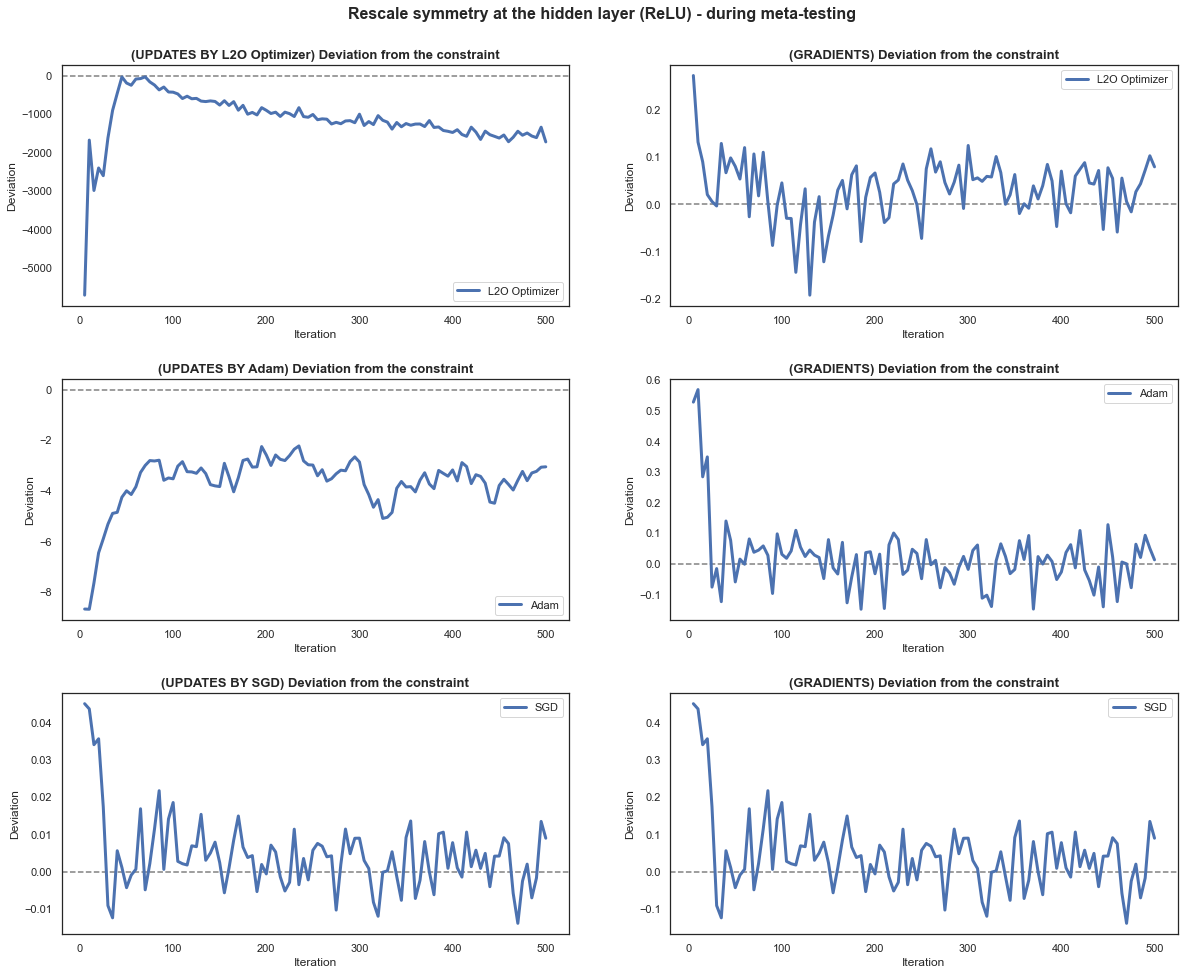

In [33]:
### plot
fig = plt.figure(figsize=(20, 16))
fig.suptitle("Rescale symmetry at the hidden layer (ReLU) - during meta-testing", fontsize=16, fontweight="bold", y=0.93)
x_ticks = np.arange(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ)

assert rescale_sym_update_deviations.keys() == rescale_sym_grad_deviations.keys()

for opter_i, opter_name in enumerate(rescale_sym_update_deviations.keys()):
    update_deviations = rescale_sym_update_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 1)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=update_deviations, linewidth=3, label=opter_name, ax=ax)
    ax.set_title(f"(UPDATES BY {opter_name}) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    ax.legend()
    # y_lims_first_ax = ax.get_ylim()

    grad_deviations = rescale_sym_grad_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 2)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=grad_deviations, linewidth=3, label=opter_name, ax=ax)
    ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    ax.legend()
    # ax.set_ylim(y_lims_first_ax)

plt.subplots_adjust(hspace=0.3)
plt.show()

### During meta-training

In [58]:
### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
rescale_sym_grad_deviations = dict()
rescale_sym_update_deviations = dict()
for epoch_i in range(0, N_EPOCHS, 20):
    rescale_sym_grad_deviations[epoch_i] = []
    rescale_sym_update_deviations[epoch_i] = []
    for iter_i in range(CKPT_ITER_FREQ, TRAINING_N_ITERS + 1, CKPT_ITER_FREQ):
        # load checkpoint
        ckpt_path = os.path.join(L2O_OPTIMIZER_CKPT_DIR, f"{L2O_OPTIMIZER_CKPT_PREFIX}{epoch_i}e_{iter_i}.pt")
        optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
            path=ckpt_path,
            optee_cls=OPTIMIZEE_CLS,
            opter_cls=OPTIMIZER_CLS,
            optee_config=OPTIMIZEE_CONFIG,
            opter_config={"preproc": OPTIMIZER_PREPROC}
        )

        # calculate deviations
        rescale_sym_grad_deviations[epoch_i].append(get_rescale_sym_constraint_deviation(
            W1=optee.layers.mat_0.weight.cpu(),
            b=optee.layers.mat_0.bias.cpu(),
            W2=optee.layers.final_mat.weight.cpu(),
            W1_update=optee_grads["layers.mat_0.weight"].cpu(),
            b_update=optee_grads["layers.mat_0.bias"].cpu(),
            W2_update=optee_grads["layers.final_mat.weight"].cpu()
        ))
        rescale_sym_update_deviations[epoch_i].append(get_rescale_sym_constraint_deviation(
            W1=optee.layers.mat_0.weight.cpu(),
            b=optee.layers.mat_0.bias.cpu(),
            W2=optee.layers.final_mat.weight.cpu(),
            W1_update=-1 * optee_updates["layers.mat_0.weight"].cpu(),
            b_update=-1 * optee_updates["layers.mat_0.bias"].cpu(),
            W2_update=-1 * optee_updates["layers.final_mat.weight"].cpu()
        ))

    rescale_sym_grad_deviations[epoch_i] = np.array(rescale_sym_grad_deviations[epoch_i])
    rescale_sym_update_deviations[epoch_i] = np.array(rescale_sym_update_deviations[epoch_i])

assert rescale_sym_update_deviations.keys() == rescale_sym_grad_deviations.keys()

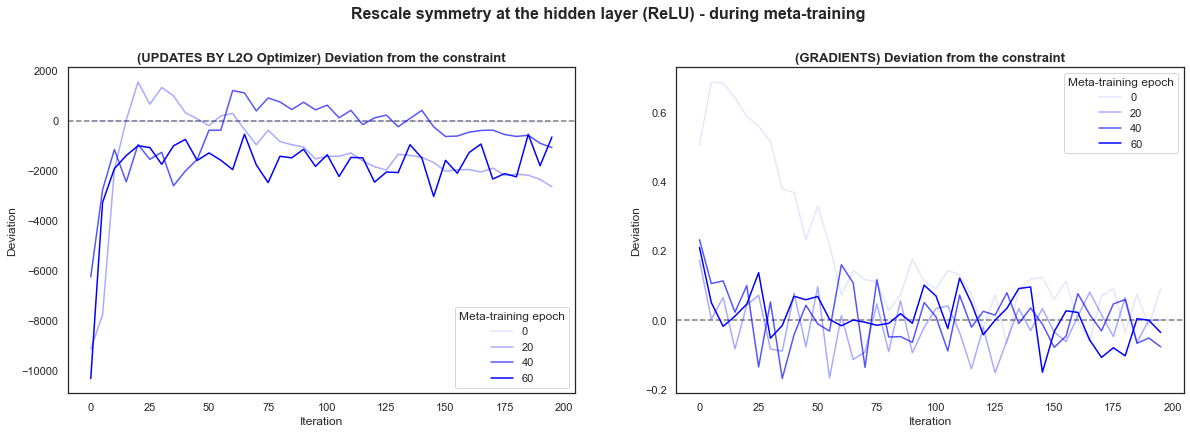

In [61]:
### plot
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Rescale symmetry at the hidden layer (ReLU) - during meta-training", fontsize=16, fontweight="bold", y=1.02)
x_ticks = np.arange(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ)
x_ticks = np.arange(0, TRAINING_N_ITERS, CKPT_ITER_FREQ)

# L2O updates' deviations
ax = fig.add_subplot(1, 2, 1)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in rescale_sym_update_deviations.keys():
    sns.lineplot(x=x_ticks, y=rescale_sym_update_deviations[epoch_i], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(rescale_sym_update_deviations.keys())), color="blue", ax=ax)

ax.set_title(f"(UPDATES BY L2O Optimizer) Deviation from the constraint", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Deviation")
ax.legend(title="Meta-training epoch")

# true gradient deviations
ax = fig.add_subplot(1, 2, 2)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in rescale_sym_grad_deviations.keys():
    sns.lineplot(x=x_ticks, y=rescale_sym_grad_deviations[epoch_i], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(rescale_sym_grad_deviations.keys())), color="blue", ax=ax)

ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Deviation")
ax.legend(title="Meta-training epoch")

plt.show()

## Translation symmetry (Softmax)

### During meta-testing

In [34]:
tranlation_sym_grad_deviations = dict()
tranlation_sym_update_deviations = dict()

In [35]:
### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
tranlation_sym_grad_deviations["L2O Optimizer"] = []
tranlation_sym_update_deviations["L2O Optimizer"] = []
for iter_i in range(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ):
    # laod checkpoint
    optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
        path=os.path.join(L2O_OPTIMIZER_CKPT_DIR, f"{L2O_OPTIMIZER_CKPT_PREFIX}{iter_i}.pt"),
        optee_cls=OPTIMIZEE_CLS,
        opter_cls=OPTIMIZER_CLS,
        optee_config=OPTIMIZEE_CONFIG,
        opter_config={"preproc": OPTIMIZER_PREPROC}
    )

    # calcualte deviations
    tranlation_sym_grad_deviations["L2O Optimizer"].append(get_translation_sym_constraint_deviations(
        W_update=optee_grads["layers.final_mat.weight"].cpu(),
        b_update=optee_grads["layers.final_mat.bias"].cpu(),
    ))
    tranlation_sym_update_deviations["L2O Optimizer"].append(get_translation_sym_constraint_deviations(
        W_update=-1 * optee_updates["layers.final_mat.weight"].cpu(),
        b_update=-1 * optee_updates["layers.final_mat.bias"].cpu(),
    ))

tranlation_sym_grad_deviations["L2O Optimizer"] = np.array(tranlation_sym_grad_deviations["L2O Optimizer"])
tranlation_sym_update_deviations["L2O Optimizer"] = np.array(tranlation_sym_update_deviations["L2O Optimizer"])
print(f"{tranlation_sym_grad_deviations['L2O Optimizer'].shape=}")
print(f"{tranlation_sym_update_deviations['L2O Optimizer'].shape=}")

tranlation_sym_grad_deviations['L2O Optimizer'].shape=(100, 2)
tranlation_sym_update_deviations['L2O Optimizer'].shape=(100, 2)


In [36]:
### Baseline optimizers
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
BASELINE_OPTERS_TO_COLLECT_FOR = list(filter(lambda opter: opter[0] in ["Adam", "SGD"], BASELINE_OPTERS))

for (opter_name, baseline_opter_cls, extra_kwargs) in BASELINE_OPTERS_TO_COLLECT_FOR:
    ckpt_prefix = f"{TARGET_CLS.__name__}_{OPTIMIZEE_CLS.__name__}_{opter_name}_"
    ckpt_dir = os.path.join(CKPT_BASE_DIR, opter_name)
    tranlation_sym_grad_deviations[opter_name] = []
    tranlation_sym_update_deviations[opter_name] = []
    for iter_i in range(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ):
        optee, opter, optee_grads, loss_history = load_baseline_opter_ckpt(
            path=os.path.join(ckpt_dir, f"{ckpt_prefix}{iter_i}.pt"),
            optee_cls=OPTIMIZEE_CLS,
            opter_cls=baseline_opter_cls,
            optee_config=OPTIMIZEE_CONFIG,
            opter_config=extra_kwargs
        )
        optee_updates = get_baseline_opter_param_updates(optee, opter)
        tranlation_sym_grad_deviations[opter_name].append(get_translation_sym_constraint_deviations(
            W_update=optee_grads["layers.mat_0.weight"].cpu(),
            b_update=optee_grads["layers.mat_0.bias"].cpu(),
        ))
        tranlation_sym_update_deviations[opter_name].append(get_translation_sym_constraint_deviations(
            W_update=-1 * optee_updates["layers.mat_0.weight"].cpu(),
            b_update=-1 * optee_updates["layers.mat_0.bias"].cpu(),
        ))
    tranlation_sym_grad_deviations[opter_name] = np.array(tranlation_sym_grad_deviations[opter_name])
    tranlation_sym_update_deviations[opter_name] = np.array(tranlation_sym_update_deviations[opter_name])
    print(f"tranlation_sym_grad_deviations[{opter_name}].shape={tranlation_sym_grad_deviations[opter_name].shape}")
    print(f"tranlation_sym_update_deviations[{opter_name}].shape={tranlation_sym_update_deviations[opter_name].shape}")

tranlation_sym_grad_deviations[Adam].shape=(100, 2)
tranlation_sym_update_deviations[Adam].shape=(100, 2)
tranlation_sym_grad_deviations[SGD].shape=(100, 2)
tranlation_sym_update_deviations[SGD].shape=(100, 2)


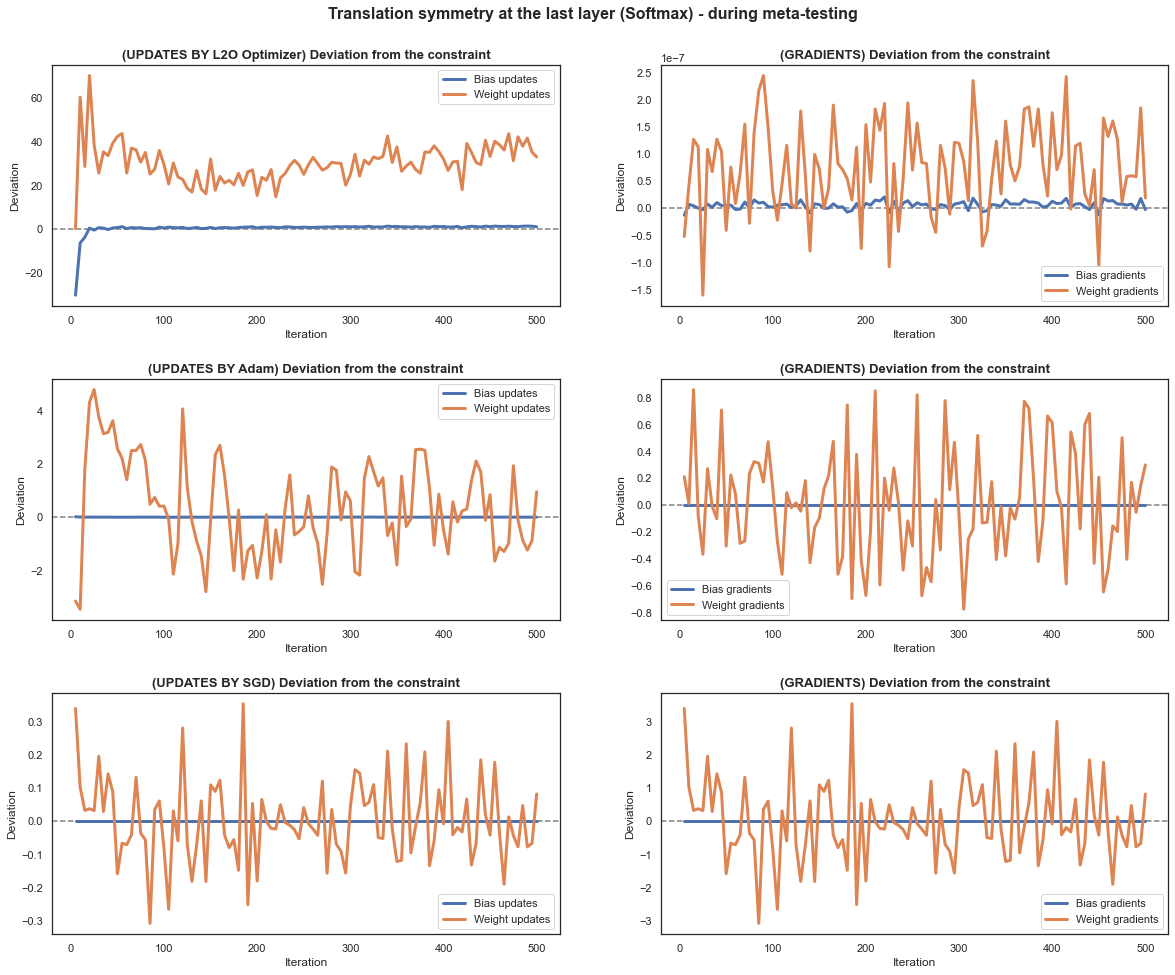

In [37]:
### plot
fig = plt.figure(figsize=(20, 16))
fig.suptitle("Translation symmetry at the last layer (Softmax) - during meta-testing", fontsize=16, fontweight="bold", y=0.93)
x_ticks = np.arange(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ)

assert tranlation_sym_grad_deviations.keys() == tranlation_sym_update_deviations.keys()

for opter_i, opter_name in enumerate(tranlation_sym_grad_deviations.keys()):
    update_deviations = tranlation_sym_update_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 1)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=update_deviations[:,1], linewidth=3, label=f"Bias updates", ax=ax)
    sns.lineplot(x=x_ticks, y=update_deviations[:,0], linewidth=3, label=f"Weight updates", ax=ax)
    ax.set_title(f"(UPDATES BY {opter_name}) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    ax.legend()
    # y_lims_first_ax = ax.get_ylim()

    grad_deviations = tranlation_sym_grad_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 2)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=grad_deviations[:,1], linewidth=3, label=f"Bias gradients", ax=ax)
    sns.lineplot(x=x_ticks, y=grad_deviations[:,0], linewidth=3, label=f"Weight gradients", ax=ax)
    ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    ax.legend()
    # ax.set_ylim(y_lims_first_ax)

plt.subplots_adjust(hspace=0.3)
plt.show()

### During meta-training

In [52]:
### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
tranlation_sym_grad_deviations = dict()
tranlation_sym_update_deviations = dict()
for epoch_i in range(0, N_EPOCHS, 20):
    tranlation_sym_grad_deviations[epoch_i] = []
    tranlation_sym_update_deviations[epoch_i] = []
    for iter_i in range(CKPT_ITER_FREQ, TRAINING_N_ITERS + 1, CKPT_ITER_FREQ):
        # load checkpoint
        ckpt_path = os.path.join(L2O_OPTIMIZER_CKPT_DIR, f"{L2O_OPTIMIZER_CKPT_PREFIX}{epoch_i}e_{iter_i}.pt")
        optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
            path=ckpt_path,
            optee_cls=OPTIMIZEE_CLS,
            opter_cls=OPTIMIZER_CLS,
            optee_config=OPTIMIZEE_CONFIG,
            opter_config={"preproc": OPTIMIZER_PREPROC}
        )

        # calculate deviations
        tranlation_sym_grad_deviations[epoch_i].append(get_translation_sym_constraint_deviations(
            W_update=optee_grads["layers.final_mat.weight"].cpu(),
            b_update=optee_grads["layers.final_mat.bias"].cpu(),
        ))
        tranlation_sym_update_deviations[epoch_i].append(get_translation_sym_constraint_deviations(
            W_update=-1 * optee_updates["layers.final_mat.weight"].cpu(),
            b_update=-1 * optee_updates["layers.final_mat.bias"].cpu(),
        ))

    tranlation_sym_grad_deviations[epoch_i] = np.array(tranlation_sym_grad_deviations[epoch_i])
    tranlation_sym_update_deviations[epoch_i] = np.array(tranlation_sym_update_deviations[epoch_i])

assert tranlation_sym_grad_deviations.keys() == tranlation_sym_update_deviations.keys()

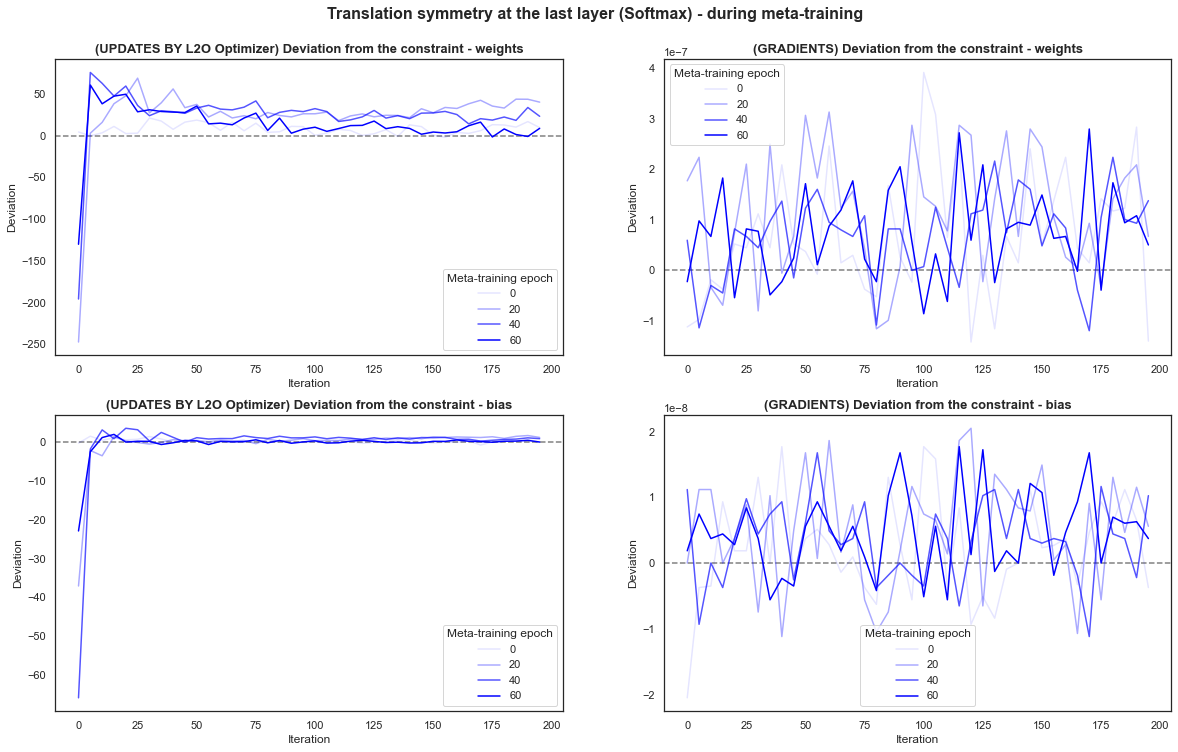

In [57]:
### plot
fig = plt.figure(figsize=(20, 12))
fig.suptitle("Translation symmetry at the last layer (Softmax) - during meta-training", fontsize=16, fontweight="bold", y=0.94)
x_ticks = np.arange(0, TRAINING_N_ITERS, CKPT_ITER_FREQ)

# L2O updates' deviations
ax_W = fig.add_subplot(2, 2, 1)
ax_b = fig.add_subplot(2, 2, 3)
ax_W.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
ax_b.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in tranlation_sym_update_deviations.keys():
    sns.lineplot(x=x_ticks, y=tranlation_sym_update_deviations[epoch_i][:,0], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(tranlation_sym_update_deviations.keys())), color="blue", ax=ax_W)
    sns.lineplot(x=x_ticks, y=tranlation_sym_update_deviations[epoch_i][:,1], linewidth=1.5, label=epoch_i,
        alpha=max(0.1, epoch_i / max(tranlation_sym_update_deviations.keys())), color="blue", ax=ax_b)

ax_W.set_title(f"(UPDATES BY L2O Optimizer) Deviation from the constraint - weights", fontsize=13, fontweight="bold")
ax_b.set_title(f"(UPDATES BY L2O Optimizer) Deviation from the constraint - bias", fontsize=13, fontweight="bold")
ax_W.set_xlabel("Iteration")
ax_b.set_xlabel("Iteration")
ax_W.set_ylabel("Deviation")
ax_b.set_ylabel("Deviation")
ax_W.legend(title="Meta-training epoch")
ax_b.legend(title="Meta-training epoch")

# true gradient deviations
ax_W = fig.add_subplot(2, 2, 2)
ax_b = fig.add_subplot(2, 2, 4)
ax_W.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
ax_b.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in tranlation_sym_grad_deviations.keys():
    sns.lineplot(x=x_ticks, y=tranlation_sym_grad_deviations[epoch_i][:,0], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(tranlation_sym_grad_deviations.keys())), color="blue", ax=ax_W)
    sns.lineplot(x=x_ticks, y=tranlation_sym_grad_deviations[epoch_i][:,1], linewidth=1.5, label=epoch_i,
        alpha=max(0.1, epoch_i / max(tranlation_sym_grad_deviations.keys())), color="blue", ax=ax_b)

ax_W.set_title("(GRADIENTS) Deviation from the constraint - weights", fontsize=13, fontweight="bold")
ax_b.set_title("(GRADIENTS) Deviation from the constraint - bias", fontsize=13, fontweight="bold")
ax_W.set_xlabel("Iteration")
ax_b.set_xlabel("Iteration")
ax_W.set_ylabel("Deviation")
ax_b.set_ylabel("Deviation")
ax_W.legend(title="Meta-training epoch")
ax_b.legend(title="Meta-training epoch")

plt.show()

## Scale symmetry (Batch normalization)

### During meta-testing

In [62]:
scale_sym_grad_deviations = dict()
scale_sym_update_deviations = dict()

In [63]:
### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
scale_sym_grad_deviations["L2O Optimizer"] = []
scale_sym_update_deviations["L2O Optimizer"] = []
for iter_i in range(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ):
    # load checkpoint
    optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
        path=os.path.join(L2O_OPTIMIZER_CKPT_DIR, f"{L2O_OPTIMIZER_CKPT_PREFIX}{iter_i}.pt"),
        optee_cls=OPTIMIZEE_CLS,
        opter_cls=OPTIMIZER_CLS,
        optee_config=OPTIMIZEE_CONFIG,
        opter_config={"preproc": OPTIMIZER_PREPROC}
    )
    
    # calculate deviations
    scale_sym_grad_deviations["L2O Optimizer"].append(get_scale_sym_constraint_deviation(
        W=optee.layers.mat_0.weight.cpu(),
        b=optee.layers.mat_0.bias.cpu(),
        W_update=optee_grads["layers.mat_0.weight"].cpu(),
        b_update=optee_grads["layers.mat_0.bias"].cpu(),
    ))
    scale_sym_update_deviations["L2O Optimizer"].append(get_scale_sym_constraint_deviation(
        W=optee.layers.mat_0.weight.cpu(),
        b=optee.layers.mat_0.bias.cpu(),
        W_update=-1 * optee_updates["layers.mat_0.weight"].cpu(),
        b_update=-1 * optee_updates["layers.mat_0.bias"].cpu(),
    ))

scale_sym_grad_deviations["L2O Optimizer"] = np.array(scale_sym_grad_deviations["L2O Optimizer"])
scale_sym_update_deviations["L2O Optimizer"] = np.array(scale_sym_update_deviations["L2O Optimizer"])
print(f"{scale_sym_grad_deviations['L2O Optimizer'].shape=}")
print(f"{scale_sym_update_deviations['L2O Optimizer'].shape=}")

scale_sym_grad_deviations['L2O Optimizer'].shape=(100,)
scale_sym_update_deviations['L2O Optimizer'].shape=(100,)


In [64]:
### Baseline optimizers
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
BASELINE_OPTERS_TO_COLLECT_FOR = list(filter(lambda opter: opter[0] in ["Adam", "SGD"], BASELINE_OPTERS))

for (opter_name, baseline_opter_cls, extra_kwargs) in BASELINE_OPTERS_TO_COLLECT_FOR:
    ckpt_prefix = f"{TARGET_CLS.__name__}_{OPTIMIZEE_CLS.__name__}_{opter_name}_"
    ckpt_dir = os.path.join(CKPT_BASE_DIR, opter_name)
    scale_sym_grad_deviations[opter_name] = []
    scale_sym_update_deviations[opter_name] = []
    for iter_i in range(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ):
        # load checkpoint
        optee, opter, optee_grads, loss_history = load_baseline_opter_ckpt(
            path=os.path.join(ckpt_dir, f"{ckpt_prefix}{iter_i}.pt"),
            optee_cls=OPTIMIZEE_CLS,
            opter_cls=baseline_opter_cls,
            optee_config=OPTIMIZEE_CONFIG,
            opter_config=extra_kwargs
        )

        # calculate deviations
        optee_updates = get_baseline_opter_param_updates(optee, opter)
        scale_sym_grad_deviations[opter_name].append(get_scale_sym_constraint_deviation(
            W=optee.layers.mat_0.weight.cpu(),
            b=optee.layers.mat_0.bias.cpu(),
            W_update=optee_grads["layers.mat_0.weight"].cpu(),
            b_update=optee_grads["layers.mat_0.bias"].cpu(),
        ))
        scale_sym_update_deviations[opter_name].append(get_scale_sym_constraint_deviation(
            W=optee.layers.mat_0.weight.cpu(),
            b=optee.layers.mat_0.bias.cpu(),
            W_update=-1 * optee_updates["layers.mat_0.weight"].cpu(),
            b_update=-1 * optee_updates["layers.mat_0.bias"].cpu(),
        ))
    scale_sym_grad_deviations[opter_name] = np.array(scale_sym_grad_deviations[opter_name])
    scale_sym_update_deviations[opter_name] = np.array(scale_sym_update_deviations[opter_name])
    print(f"scale_sym_grad_deviations[{opter_name}].shape={scale_sym_grad_deviations[opter_name].shape}")
    print(f"scale_sym_update_deviations[{opter_name}].shape={scale_sym_update_deviations[opter_name].shape}")

scale_sym_grad_deviations[Adam].shape=(100,)
scale_sym_update_deviations[Adam].shape=(100,)
scale_sym_grad_deviations[SGD].shape=(100,)
scale_sym_update_deviations[SGD].shape=(100,)


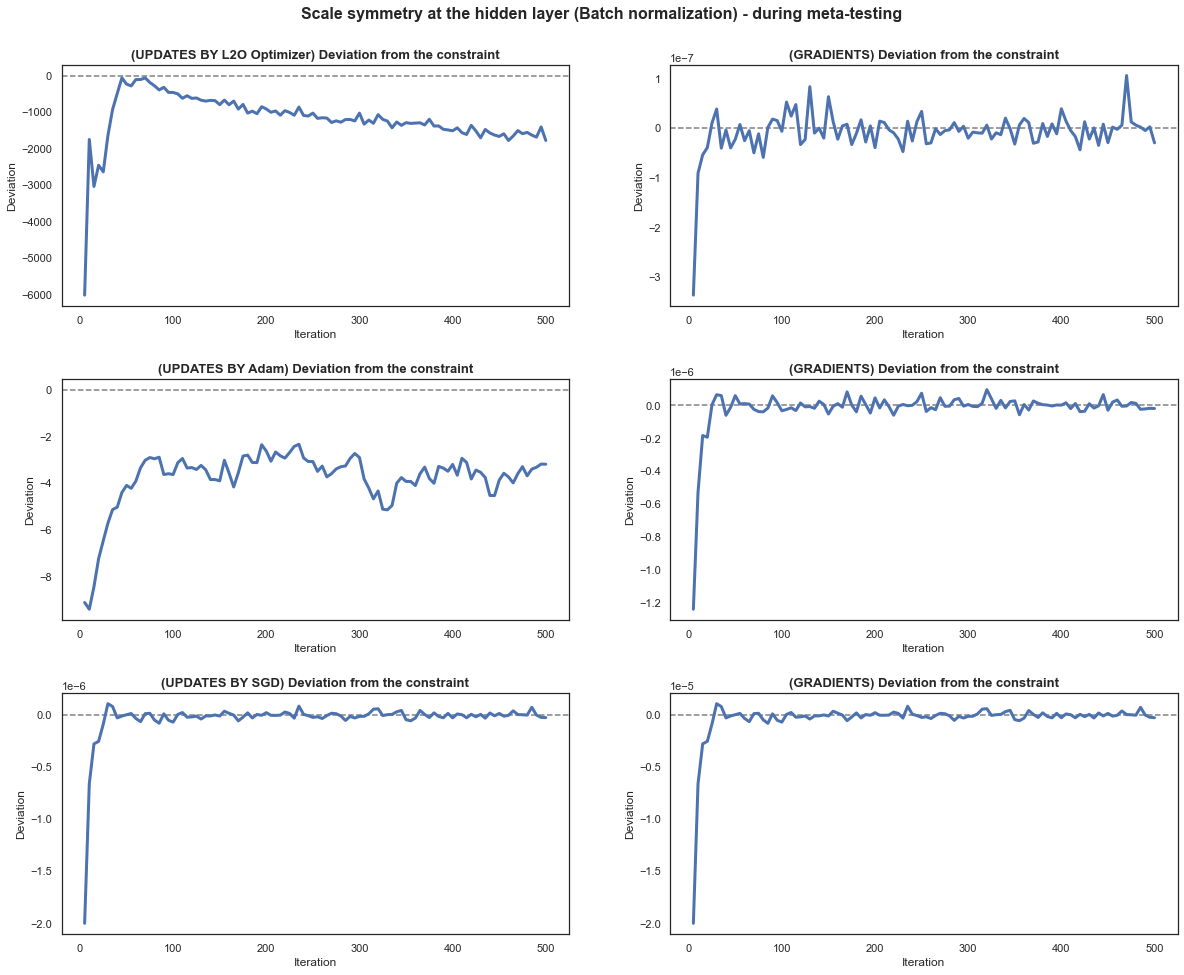

In [66]:
### plot
fig = plt.figure(figsize=(20, 16))
fig.suptitle("Scale symmetry at the hidden layer (Batch normalization) - during meta-testing", fontsize=16, fontweight="bold", y=0.93)
x_ticks = np.arange(CKPT_ITER_FREQ, N_ITERS + 1, CKPT_ITER_FREQ)

assert scale_sym_grad_deviations.keys() == scale_sym_update_deviations.keys()

for opter_i, opter_name in enumerate(scale_sym_grad_deviations.keys()):
    update_deviations = scale_sym_update_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 1)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=update_deviations, linewidth=3, ax=ax)
    ax.set_title(f"(UPDATES BY {opter_name}) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    # y_lims_first_ax = ax.get_ylim()

    grad_deviations = scale_sym_grad_deviations[opter_name]
    ax = fig.add_subplot(3, 2, 2*opter_i + 2)
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)
    sns.lineplot(x=x_ticks, y=grad_deviations, linewidth=3, ax=ax)
    ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation")
    # ax.set_ylim(y_lims_first_ax)

plt.subplots_adjust(hspace=0.3)
plt.show()

### During meta-training

In [67]:
### L2O optimizer
# collect left-hand sides of the equation from the neural mechanics paper which should be equal to 0
scale_sym_grad_deviations = dict()
scale_sym_update_deviations = dict()
for epoch_i in range(0, N_EPOCHS, 20):
    scale_sym_grad_deviations[epoch_i] = []
    scale_sym_update_deviations[epoch_i] = []
    for iter_i in range(CKPT_ITER_FREQ, TRAINING_N_ITERS + 1, CKPT_ITER_FREQ):
        # load checkpoint
        ckpt_path = os.path.join(L2O_OPTIMIZER_CKPT_DIR, f"{L2O_OPTIMIZER_CKPT_PREFIX}{epoch_i}e_{iter_i}.pt")
        optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
            path=ckpt_path,
            optee_cls=OPTIMIZEE_CLS,
            opter_cls=OPTIMIZER_CLS,
            optee_config=OPTIMIZEE_CONFIG,
            opter_config={"preproc": OPTIMIZER_PREPROC}
        )

        # calculate deviations
        scale_sym_grad_deviations[epoch_i].append(get_scale_sym_constraint_deviation(
            W=optee.layers.mat_0.weight.cpu(),
            b=optee.layers.mat_0.bias.cpu(),
            W_update=optee_grads["layers.mat_0.weight"].cpu(),
            b_update=optee_grads["layers.mat_0.bias"].cpu(),
        ))
        scale_sym_update_deviations[epoch_i].append(get_scale_sym_constraint_deviation(
            W=optee.layers.mat_0.weight.cpu(),
            b=optee.layers.mat_0.bias.cpu(),
            W_update=-1 * optee_updates["layers.mat_0.weight"].cpu(),
            b_update=-1 * optee_updates["layers.mat_0.bias"].cpu(),
        ))

    scale_sym_grad_deviations[epoch_i] = np.array(scale_sym_grad_deviations[epoch_i])
    scale_sym_update_deviations[epoch_i] = np.array(scale_sym_update_deviations[epoch_i])

assert scale_sym_grad_deviations.keys() == scale_sym_update_deviations.keys()

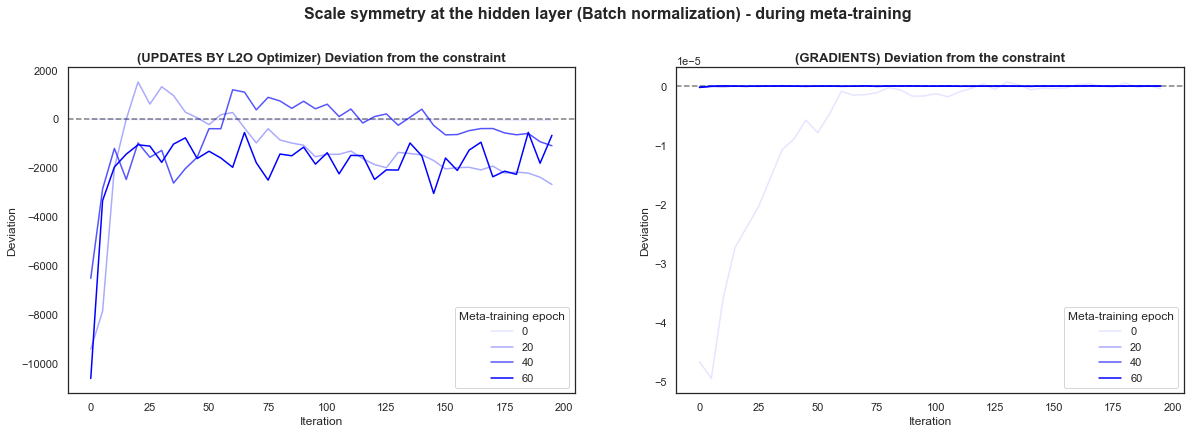

In [70]:
### plot
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Scale symmetry at the hidden layer (Batch normalization) - during meta-training", fontsize=16, fontweight="bold", y=1.02)
x_ticks = np.arange(0, TRAINING_N_ITERS, CKPT_ITER_FREQ)

# L2O updates' deviations
ax = fig.add_subplot(1, 2, 1)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in scale_sym_update_deviations.keys():
    sns.lineplot(x=x_ticks, y=scale_sym_update_deviations[epoch_i], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(scale_sym_update_deviations.keys())), color="blue", ax=ax)

ax.set_title(f"(UPDATES BY L2O Optimizer) Deviation from the constraint", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Deviation")
ax.legend(title="Meta-training epoch")

# true gradient deviations
ax = fig.add_subplot(1, 2, 2)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=1.5)

for epoch_i in scale_sym_grad_deviations.keys():
    sns.lineplot(x=x_ticks, y=scale_sym_grad_deviations[epoch_i], linewidth=1.5, label=epoch_i, 
        alpha=max(0.1, epoch_i / max(scale_sym_grad_deviations.keys())), color="blue", ax=ax)

ax.set_title("(GRADIENTS) Deviation from the constraint", fontsize=13, fontweight="bold")
ax.set_xlabel("Iteration")
ax.set_ylabel("Deviation")
ax.legend(title="Meta-training epoch")

plt.show()